In [9]:
import sys
#add local qiskit-terra/test/python path here to import transpiler._dummy_passes
#test_path='<enter path here>'
sys.path.append(test_path)

In [10]:
from transpiler import test_pass_scheduler
from qiskit import QuantumCircuit,QuantumRegister
from qiskit.transpiler import PassManager
from qiskit.transpiler.runningpassmanager import ConditionalController,DoWhileController
from transpiler._dummy_passes import (
    PassA_TP_NR_NP,
    PassB_TP_RA_PA,
    PassC_TP_RA_PA,
    PassD_TP_NR_NP,
    PassE_AP_NR_NP,
    PassF_reduce_dag_property,
    PassI_Bad_AP,
    PassJ_Bad_NoReturn,
    PassK_check_fixed_point_property,
    PassM_AP_NR_NP,
)

In [11]:
from transpiler.test_pass_scheduler import SchedulerTestCase

def show_run(passmanager,circuit):
    myScheduler=SchedulerTestCase()

    with myScheduler.assertLogs("LocalLogger", level="INFO") as cm:
        out = passmanager.run(circuit)
    return [record.message for record in cm.records]

# Nested Flow Controllers

### <font color=purple>Pass Manager</font>
Schedules and runs transpiler passes; allows communication between passes via property set.

## <font color=green>PR #6962</font>
This is another approach to fix issue <font color=blue>#6830</font> which uses nested `FlowControllers` (like `ConditionalController`) to nest conditionals within loops in `PassManager`.





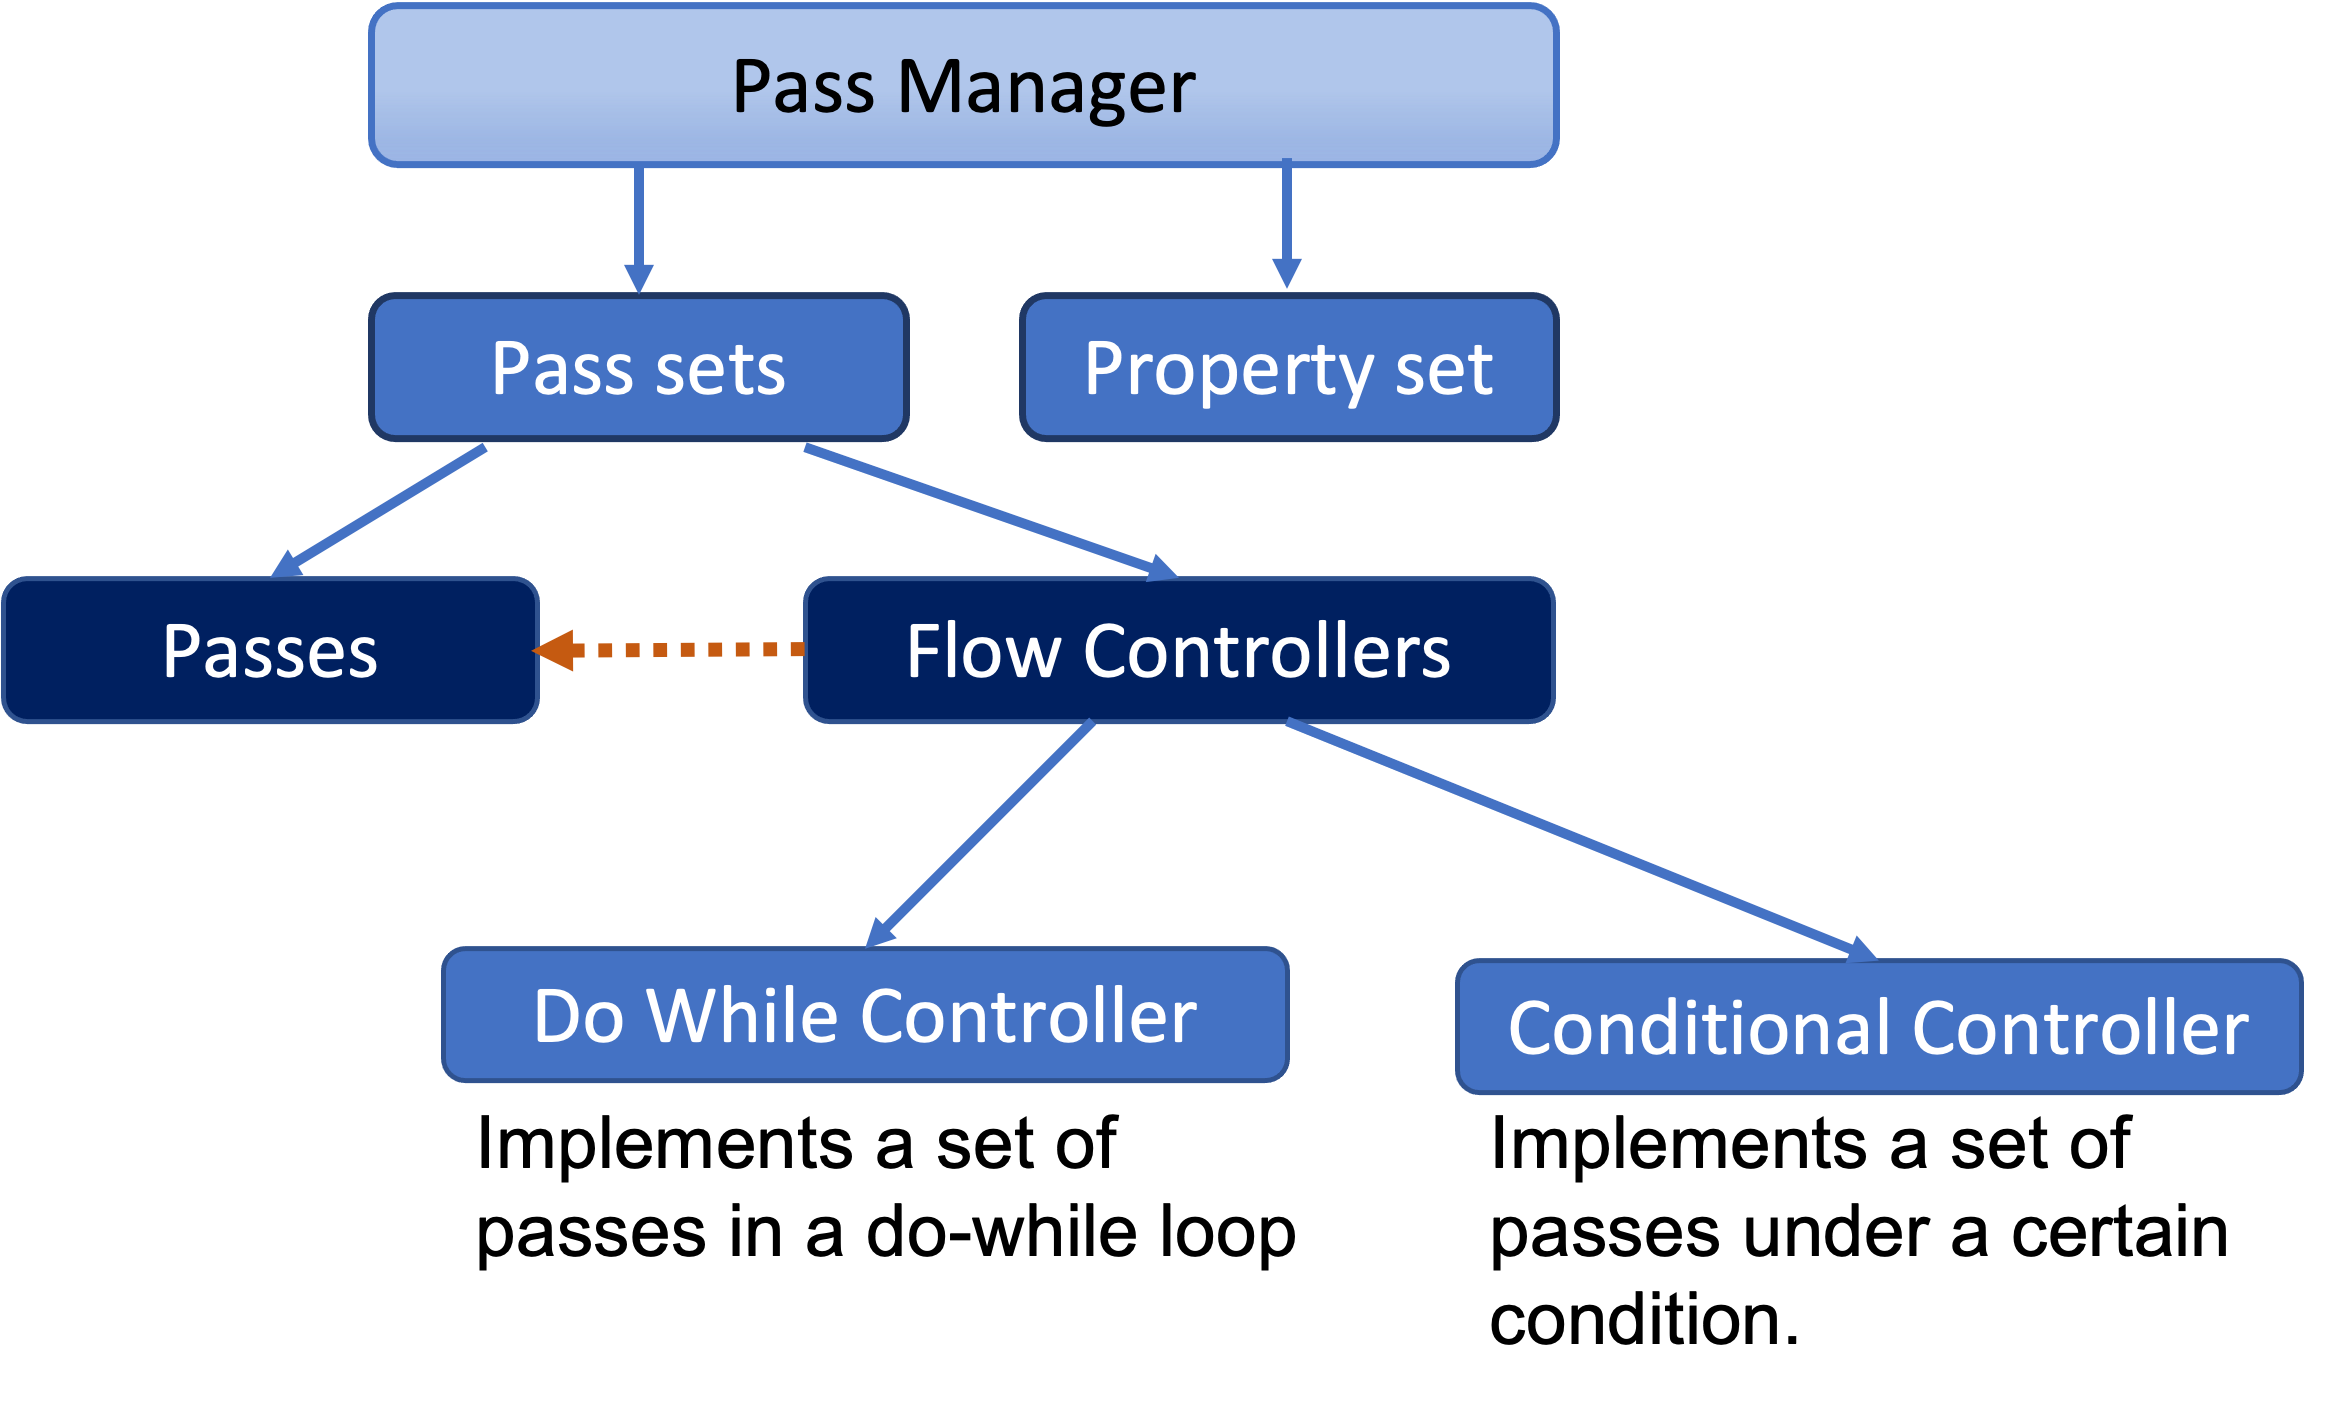

In [12]:
#Creating a nested ConditionalController

#Defining PassManager and circuit
passmanager=PassManager()
circuit = QuantumCircuit(QuantumRegister(1))

#Runs PassA_TP_NR_NP if property_set["property"] is True
#Passes like PassA_TP_NR_NP are just test passes used in the test suite

nested_conditional=[ConditionalController(
                    [PassA_TP_NR_NP()], 
                    condition=lambda property_set: property_set["property"])]

passmanager.append([PassE_AP_NR_NP(True)] +
                   nested_conditional)

show_run(passmanager,circuit)



['run analysis pass PassE_AP_NR_NP',
 'set property as True',
 'run transformation pass PassA_TP_NR_NP']

In [5]:
#Nesting a ConditionalController inside of a loop

#Defining PassManager and circuit
passmanager=PassManager()
circuit = QuantumCircuit(QuantumRegister(1))

#Runs PassA_TP_NR_NP if property_set["property"] is True

nested_conditional=[ConditionalController(
                    [PassA_TP_NR_NP()], 
                    condition=lambda property_set: property_set["property"])]

passmanager.append([PassK_check_fixed_point_property(), PassE_AP_NR_NP(True)] 
                   + nested_conditional 
                   + [PassF_reduce_dag_property()],
                   do_while=lambda property_set: not property_set["property_fixed_point"])

show_run(passmanager,circuit)

['run analysis pass PassG_calculates_dag_property',
 'set property as 8 (from dag.property)',
 'run analysis pass PassK_check_fixed_point_property',
 'run analysis pass PassE_AP_NR_NP',
 'set property as True',
 'run transformation pass PassA_TP_NR_NP',
 'run transformation pass PassF_reduce_dag_property',
 'dag property = 6',
 'run analysis pass PassG_calculates_dag_property',
 'set property as 6 (from dag.property)',
 'run analysis pass PassK_check_fixed_point_property',
 'run analysis pass PassE_AP_NR_NP',
 'set property as True',
 'run transformation pass PassA_TP_NR_NP',
 'run transformation pass PassF_reduce_dag_property',
 'dag property = 5',
 'run analysis pass PassG_calculates_dag_property',
 'set property as 5 (from dag.property)',
 'run analysis pass PassK_check_fixed_point_property',
 'run analysis pass PassE_AP_NR_NP',
 'set property as True',
 'run transformation pass PassA_TP_NR_NP',
 'run transformation pass PassF_reduce_dag_property',
 'dag property = 4',
 'run analysi

In [6]:
#Nesting ConditionalControllers more than one level

passmanager=PassManager()
circuit = QuantumCircuit(QuantumRegister(1))

nested_level3=ConditionalController([PassC_TP_RA_PA()], condition=lambda property_set: property_set["property"])
nested_level2=ConditionalController([PassF_reduce_dag_property(),nested_level3],condition=lambda property_set: property_set["property"])
nested_level1=[ConditionalController([PassA_TP_NR_NP(),nested_level2], condition=lambda property_set: property_set["property"])]


passmanager.append([PassE_AP_NR_NP(True)] 
                    + nested_level1)
show_run(passmanager,circuit)

['run analysis pass PassE_AP_NR_NP',
 'set property as True',
 'run transformation pass PassA_TP_NR_NP',
 'run transformation pass PassF_reduce_dag_property',
 'dag property = 6',
 'run transformation pass PassA_TP_NR_NP',
 'run transformation pass PassC_TP_RA_PA']

In [7]:
#Multiple nested ConditionalControllers on the same level
passmanager=PassManager()
circuit = QuantumCircuit(QuantumRegister(1))

nested_conditional1=[ConditionalController([PassB_TP_RA_PA()], condition=lambda property_set: property_set["property"])]
nested_conditional2=[ConditionalController([PassC_TP_RA_PA()], condition=lambda property_set: property_set["property"])]
nested_conditional3=[ConditionalController([PassD_TP_NR_NP()], condition=lambda property_set: property_set["property"])]


passmanager.append([PassE_AP_NR_NP(True)]
                    + nested_conditional1 
                    + [PassE_AP_NR_NP(False)]
                    + nested_conditional2
                    + [PassE_AP_NR_NP(True)]
                    + nested_conditional3)

show_run(passmanager,circuit)           

['run analysis pass PassE_AP_NR_NP',
 'set property as True',
 'run transformation pass PassA_TP_NR_NP',
 'run transformation pass PassB_TP_RA_PA',
 'run analysis pass PassE_AP_NR_NP',
 'set property as False',
 'run analysis pass PassE_AP_NR_NP',
 'set property as True',
 'run transformation pass PassD_TP_NR_NP',
 'argument None']

In [8]:
#Nested DoWhileController
passmanager=PassManager()
circuit = QuantumCircuit(QuantumRegister(1))

nested_do_while = [DoWhileController([PassK_check_fixed_point_property(),PassF_reduce_dag_property()],
                    do_while=lambda property_set: not property_set["property_fixed_point"])]

passmanager.append([PassD_TP_NR_NP()]
                    + nested_do_while
                    + [PassD_TP_NR_NP()])

show_run(passmanager,circuit)

['run transformation pass PassD_TP_NR_NP',
 'argument None',
 'run analysis pass PassG_calculates_dag_property',
 'set property as 8 (from dag.property)',
 'run analysis pass PassK_check_fixed_point_property',
 'run transformation pass PassF_reduce_dag_property',
 'dag property = 6',
 'run analysis pass PassG_calculates_dag_property',
 'set property as 6 (from dag.property)',
 'run analysis pass PassK_check_fixed_point_property',
 'run transformation pass PassF_reduce_dag_property',
 'dag property = 5',
 'run analysis pass PassG_calculates_dag_property',
 'set property as 5 (from dag.property)',
 'run analysis pass PassK_check_fixed_point_property',
 'run transformation pass PassF_reduce_dag_property',
 'dag property = 4',
 'run analysis pass PassG_calculates_dag_property',
 'set property as 4 (from dag.property)',
 'run analysis pass PassK_check_fixed_point_property',
 'run transformation pass PassF_reduce_dag_property',
 'dag property = 3',
 'run analysis pass PassG_calculates_dag_pr

# Making 1Q Sequences produced by the synthesis routine with optimization level 3 efficient

## <font color=green>PR #6940</font>

This PR addresses issue <font color=blue>#6677</font> by adding a conditional to check if gates are in the basis (using the `GatesInBasis` analysis pass in PR #6832), and then running `_unroll` only when necessary in Level 3 (heavy weight optimization level) using a nested `FlowController` for a nested conditional (using PR #6962).

Basis translation done by `_unroll` introduces the inefficient sequences like this when provided a complex quantum circuit like Quantum Volume, synthesis routine, and high optimization level:

<div>
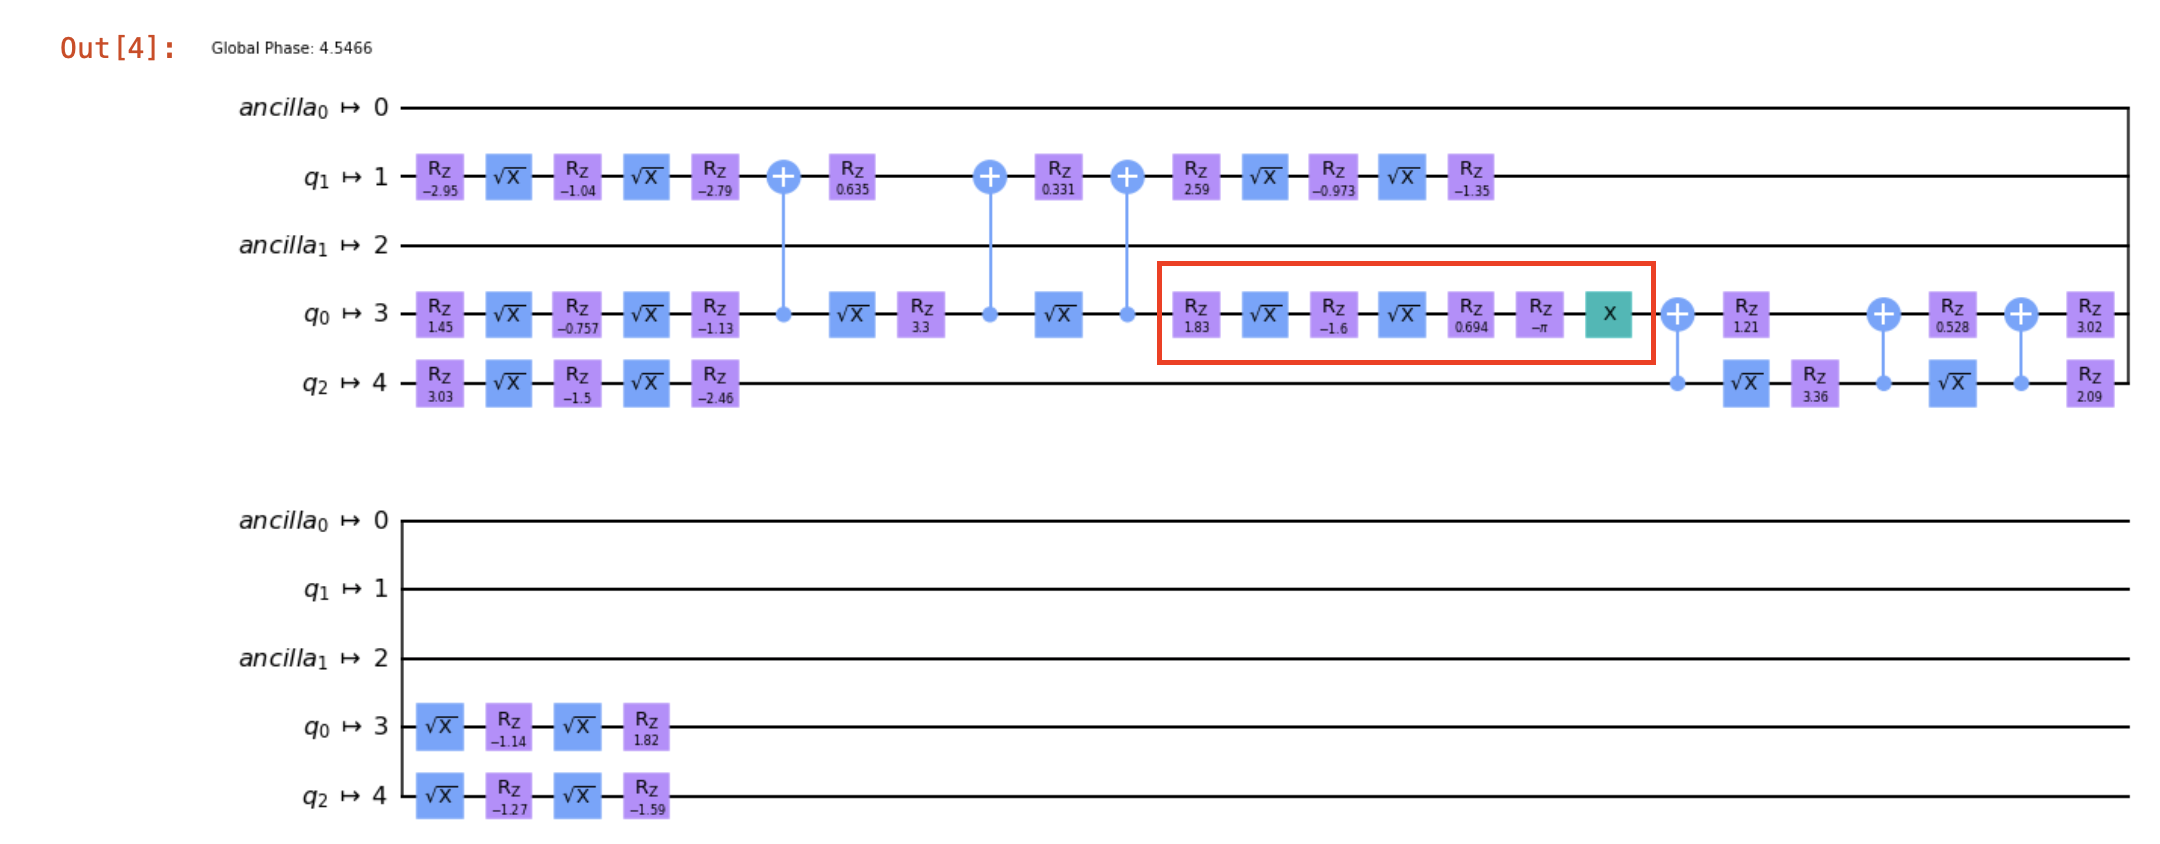
</div>

`_unroll` is a python list of passes in the PassManager that for Level 3 and the synthesis routine consists of Unroll3qOrMore,Collect2qBlocks, ConsolidateBlocks, UnitarySynthesis


1. `_unroll_check` runs the GatesInBasis analysis pass scans dag to check if there are gates outside the basis and sets the property `property_set["all_gates_in_basis"]`
2. `_unroll_condition` checks if `property_set["all_gates_in_basis"]` is True. If the property `all_gates_in_basis` is True, then it returns False so `_unroll` will not be run. Otherwise, if property `all_gates_in_basis` is False, then it returns True so `_unroll` will be run.
3. Nested flow controller ConditionalController is used to run `_unroll` only if `_unroll_condition` is True, otherwise it skips the `_unroll` passes in the do_while loop.




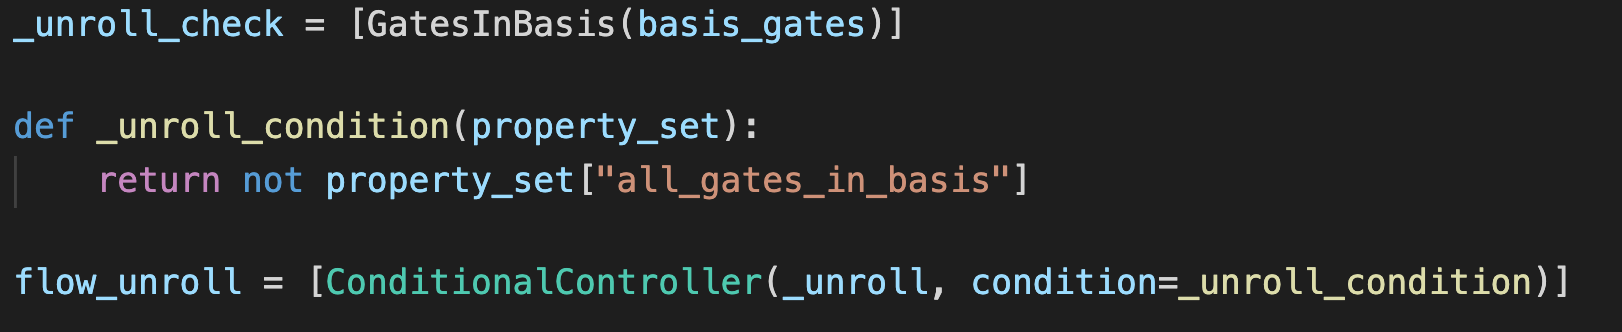




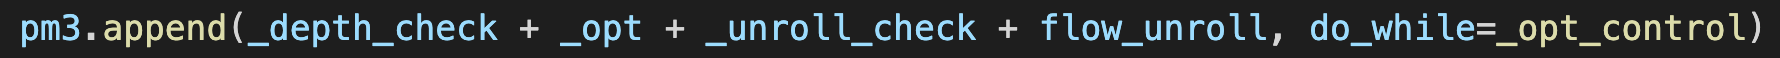

Unroll3qOrMore
RemoveResetInZeroState
OptimizeSwapBeforeMeasure
RemoveDiagonalGatesBeforeMeasure
SetLayout
TrivialLayout
Layout2qDistance
CSPLayout
FullAncillaAllocation
EnlargeWithAncilla
ApplyLayout
CheckMap
Unroll3qOrMore
Collect2qBlocks
ConsolidateBlocks
UnitarySynthesis
RemoveResetInZeroState
Depth
FixedPoint
Collect2qBlocks
ConsolidateBlocks
UnitarySynthesis
Optimize1qGatesDecomposition
CommutationAnalysis
CommutativeCancellation
GatesInBasis
Depth
FixedPoint
Collect2qBlocks
ConsolidateBlocks
UnitarySynthesis
Optimize1qGatesDecomposition
CommutationAnalysis
CommutativeCancellation
GatesInBasis
TimeUnitConversion
ValidatePulseGates
AlignMeasures


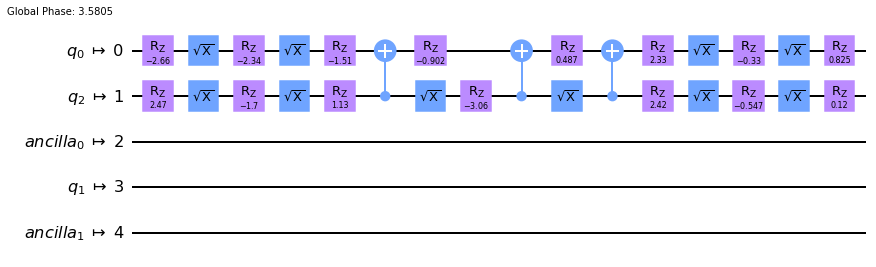

In [13]:
from qiskit.circuit.library import QuantumVolume
from qiskit import *


from qiskit.test.mock import FakeBelem
qcomp = FakeBelem()

qv_circuit=QuantumVolume(3)
qv_circuit.draw()

from IPython.display import display
from qiskit.converters import dag_to_circuit
from qiskit.transpiler import TransformationPass
from qiskit.converters import dag_to_circuit


def my_callback(pass_,dag, time, property_set, count):   
    circuit = dag_to_circuit(dag)
    print(pass_.name())
    #display(circuit.draw(output='mpl'))
    circuit = dag_to_circuit(dag)

transpile(qv_circuit,backend=qcomp, optimization_level=3,callback=my_callback,translation_method='synthesis').draw(output='mpl')



## Benefits

• Uses properties in `PassManager` nested `FlowControllers` are contained in, so this approach doesn't have to copy these properties <br>
• Uniform results (produces efficient sequences) for PR #6940: Making sequences produced by the synthesis routine and optimization level 3 efficient <br>

## Limitations
• `PassManagers` can do more than `FlowControllers`, so nested `PassManagers` will allow for much more complex functionality